# Exploring Techniques for Analyzing N42 Gamma Spectra with Python (Part 1?)

The goal of this project is to practice and demonstrate my knowledge of gamma detection systems and the N42 file format, as well as to document some of my initial, naive approach for parsing and analyzing N42 files with Python. Resources I used for this project include the N42 file format standard ([available here](https://ieeexplore.ieee.org/document/9264644)) and LLNL RASE ([Github here](https://github.com/LLNL/RASE), [credited here](rase_functions_copied.py)). Because this project is educational, and I'm leaning heavily on others work, I'll warn it's possible I've made a mistake either in the coding or physics side. 

## Background
Many gamma detection systems are spectroscopic, meaning they measure a range of photon energy values, i.e., a spectrum. The energy profiles emitted by radioactive materials are typically known, so the measured spectroscopic data can be used as a "fingerprint" to identify materials. In the figure below, you can see how the measured spectra is used to to identify the nuclides Ra-226, Pb-214, and Bi-214 of the uranium decay chain.

<a title="Wusel007, CC BY-SA 3.0 &lt;https://creativecommons.org/licenses/by-sa/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Gammaspektrum_Uranerz.jpg"><img width="512" alt="Gammaspektrum Uranerz" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Gammaspektrum_Uranerz.jpg/512px-Gammaspektrum_Uranerz.jpg"></a>

Many spectroscopic instruments output spectroscopic data within files that follow the N42.42 standard. [As described by NIST](https://www.nist.gov/programs-projects/documentary-standards-ansiieee-n4242-standard), "the ANSI/IEEE N42.42 standard specifies the XML data format that shall be used for both required and optional data to be made available by radiation measurement instruments.", and they also mention its purpose is "to facilitate manufacturer-independent transfer of information from radiation measurement instruments for use in homeland security applications as well as for detection of illicit trafficking of radioactive material".

These files more-or-less contains all the information necessary to assess the spectrum and/or radionuclide identification results. The standard defines the required and optional data elements and how they can be organized. It is also flexible enough to account for the various types of instruments defined in the other ANSI/IEEE N42 Radiation Detection Standards, from handhelds to portal monitors.

The latest version of the N42 file format, N42.N42.2020, can be downloaded for free [from the IEEE website](https://ieeexplore.ieee.org/document/9264644) (but you have to sign-up for an account). In the standard, there are a few N42 file examples given. I've extracted and saved [one](input/n42_example_riid.n42) of these to play around with.

## Reading a spectra from an example N42
The example I took from the N42 standard has the following characteristics:
- Taken off of a fictional/anonymized radioisotope identification device (RID), the "iRID" from manufacturer "RIDs R Us".
- Measured spectrum (foreground) and background spectrum. 
- Single energy calibration metadata for both spectra.
- Identification results

To parse the file's data, I've taken a page from RASE and set-up a YAML configuration file which specifies the [xpaths](https://en.wikipedia.org/wiki/XPath) of data elements. 

Side note: despite the intuition of being a "standard", every manufactrer will have different N42 file formats. Certain elements will always have the same name or structured in same way, but, as described earlier, there are various ways to structure and extend the information depending on the instrument, application, etc. In our example we only have on manufactrer, but if there were more, each one would need a seperate set of xpaths defined in the YAML config.

### Grab filenames of N42s
In this case, just one.

In [1]:
# Get filenames of N42s (in thise case, just one)
import glob
n42_files = []
indir = 'input/'
n42_files.extend(glob.glob(indir + '*.n42'))

### Set-up data elements xpath configurations

In [2]:
import yaml
from lxml import etree as ET

def join(loader, node):
    seq = loader.construct_sequence(node)
    return ''.join([str(i) for i in seq])

yaml.SafeLoader.add_constructor(tag='!join', constructor=join)

n42_config_yaml_str = """
    iRID:
        intrument_base: &IB ./RadInstrumentInformation
        instrument_manuf_xpath: !join [*IB, /RadInstrumentManufacturerName/text()]
        instrument_model_xpath: !join [*IB, /RadInstrumentModelName/text()]
        instrument_identifier_xpath: !join [*IB, /RadInstrumentIdentifier/text()]
        calibration_base: &CB ./EnergyCalibration
        calibration_id_xpath: !join [*CB, /@id]
        calibration_coefval_xpath: !join [*CB,/CoefficientValues/text()]
        calibration_remark_xpath: !join [*CB, /Remark/text()]
        
        radmeasurement_bkg: &RMB ./RadMeasurement[MeasurementClassCode="Background"]
        bgk_id_xpath: !join [*RMB,/@id]
        bgk_mcc_xpath: !join [*RMB,/MeasurementClassCode/text()]
        bgk_realtime_xpath: !join [*RMB,/RealTimeDuration/text()]
        bgk_startdt_xpath: !join [*RMB,/StartDateTime/text()]
        
        spectrum_bkg: &SB !join [*RMB,/Spectrum]
        bgk_spectrum_id_xpath: !join [*SB,/@id]
        bgk_spectrum_calibref_xpath: !join [*SB,/@energyCalibrationReference]
        bgk_spectrum_channeldata_xpath: !join [*SB,/ChannelData/text()]
        bgk_spectrum_chdata_compcode_xpath: !join [*SB,/ChannelData/@compressionCode]
        bgk_spectrum_livetime_xpath: !join [*SB,/LiveTimeDuration/text()]
        
        radmeasurement_frg: &RMF ./RadMeasurement[MeasurementClassCode="Foreground"]
        fgr_id_xpath: !join [*RMF,/@id]
        fgr_mcc_xpath: !join [*RMF,/MeasurementClassCode/text()]
        fgr_realtime_xpath: !join [*RMF,/RealTimeDuration/text()]
        fgr_startdt_xpath: !join [*RMF,/StartDateTime/text()]
        
        spectrum_fg: &SF !join [*RMF,/Spectrum]
        fgr_spectrum_id_xpath: !join [*SF,/@id]
        fgr_spectrum_calibref_xpath: !join [*SF,/@energyCalibrationReference]
        fgr_spectrum_channeldata_xpath: !join [*SF,/ChannelData/text()]
        fgr_spectrum_chdata_compcode_xpath: !join [*SF,/ChannelData/@compressionCode]
        fgr_spectrum_livetime_xpath: !join [*SF,/LiveTimeDuration/text()]

        result_base: &RB ./AnalysisResults
        result_id_xpath: !join [*RB,/@id]
        result_rmgr_xpath: !join [*RB,/@radMeasurementGroupReferences]
        result_nucldies_xpath: !join [*RB,/NuclideAnalysisResults/Nuclide/NuclideName/text()]
"""   

n42_config = yaml.safe_load(n42_config_yaml_str)

### Parse N42 file into dataframe
Using pandas dataframe to 'hold' the data. All of the file's data translates into a row in the dataframe. If there were multiple files, there would be multiple rows, etc.

In [3]:
import pandas as pd
import rase_functions_copied as rf

df_n42 = pd.DataFrame()
df_n42_list = []
elems_dict = {}
for i,f in enumerate(n42_files):
    tree = ET.parse(f)
    tree = rf.strip_namespaces(tree)
    root = tree.getroot()
    etemp = {}
    etemp['filename'] = f
    model = tree.xpath('./RadInstrumentInformation/RadInstrumentModelName//text()')[0]
    config = n42_config[model]
    for key, val in config.items():
        if 'base' in key:
            continue
        e = tree.xpath(val)
        if len(e) == 1 and (key != 'result_nuclides_xpath'):
            e = e[0]
        etemp[key.replace('_xpath','')] = e
    elems_dict[f] = etemp
df_n42 = pd.DataFrame.from_dict(elems_dict, orient='index').reset_index(drop=True)
# display(df_n42['msr_startdt'])
df_n42.melt()

,variable,value
0,filename,input\n42_example_riid.n42
1,instrument_manuf,RIDs R Us
2,instrument_model,iRID
3,instrument_identifier,SN 7890A
4,calibration_id,EnergyCalibration-1
5,calibration_coefval,-21.8 12.1 6.55e-03
6,calibration_remark,[]
7,radmeasurement_bkg,"[[], [], [], [[], []], [[], []], [[]]]"
8,bgk_id,RadMeasurement-1
9,bgk_mcc,Background


## Some clean-up / pre-processing
Basically getting dataframe in better shape for analysis. Some of this could of been avoided if I had parsed data better, I think.

In [4]:
# Melting dataframe (regret parsing file into one row)
idx = ['filename', 'instrument_manuf', 'instrument_model',
       'instrument_identifier', 'calibration_id', 'calibration_coefval',
       'calibration_remark', 'result_id', 'result_rmgr', 'result_nucldies']
mc = ['id','mcc','realtime','startdt','spectrum_id','spectrum_calibref','spectrum_channeldata','spectrum_chdata_compcode','spectrum_livetime']
df_n42_m = df_n42.melt(id_vars=idx, value_vars=['bgk_id','fgr_id'], value_name='msr_id').drop(columns='variable')
for c in mc[1:]:
    df_n42_m['msr_' + c] = df_n42.melt(value_vars=['bgk_'+c,'fgr_'+c]).drop(columns='variable')

# convert to list, cast to float, reverse for polyval function
df_n42_m['calibration_coefval'] = (
    df_n42_m['calibration_coefval']
    .str.split(' ')
    .apply(lambda x: [float(v) for v in x])
    .apply(lambda x: list(reversed(x))) 
)
# convert to datetime
df_n42_m['msr_startdt'] = pd.to_datetime(df_n42_m['msr_startdt'])
# convert to list, cast to int
df_n42_m['msr_spectrum_channeldata'] = (
    df_n42_m['msr_spectrum_channeldata']
    .str.replace('\n','')
    .str.replace(' +',' ',regex=True)
    .str.strip().str.split(' ')
    .apply(lambda x: [int(v) for v in x])
)

# Account for compression algorithm
cz = df_n42_m['msr_spectrum_chdata_compcode'] == 'CountedZeroes'
df_n42_m.loc[cz,'msr_spectrum_channeldata'] = (
    df_n42_m['msr_spectrum_channeldata'].apply(rf.uncompressCountedZeroes)
)
# go ahead and split calibration coefficients into 3 columns
# makes for slightly easier processing ahead
df_n42_m[['calib_coef_2','calib_coef_1','calib_coef_0']] = pd.DataFrame(df_n42_m['calibration_coefval'].tolist(), index= df_n42_m.index)
df_n42_m = df_n42_m[['filename', 'instrument_manuf', 'instrument_model',
       'instrument_identifier', 'calibration_id', 'calib_coef_2', 'calib_coef_1', 'calib_coef_0',
       'calibration_remark', 'msr_id', 'msr_mcc','msr_realtime', 'msr_startdt',
       'msr_spectrum_id', 'msr_spectrum_calibref', 'msr_spectrum_channeldata',
       'msr_spectrum_livetime', 'result_id', 'result_rmgr', 'result_nucldies']]

df_n42_m

,filename,instrument_manuf,instrument_model,instrument_identifier,calibration_id,calib_coef_2,calib_coef_1,calib_coef_0,calibration_remark,msr_id,msr_mcc,msr_realtime,msr_startdt,msr_spectrum_id,msr_spectrum_calibref,msr_spectrum_channeldata,msr_spectrum_livetime,result_id,result_rmgr,result_nucldies
0,input\n42_example_riid.n42,RIDs R Us,iRID,SN 7890A,EnergyCalibration-1,0.00655,12.1,-21.8,[],RadMeasurement-1,Background,PT60S,2003-11-22 23:35:30-07:00,RadMeasurement-1-Spectrum-1,EnergyCalibration-1,"[0, 0, 0, 22, 421, 847, 1295, 1982, 2127, 2222...",PT59.7S,AnalysisResults-1,RadMeasurementGroup-1,"[Cs-137, K-40]"
1,input\n42_example_riid.n42,RIDs R Us,iRID,SN 7890A,EnergyCalibration-1,0.00655,12.1,-21.8,[],RadMeasurement-2,Foreground,PT60S,2003-11-22 23:45:19-07:00,RadMeasurement-2-Spectrum-2,EnergyCalibration-1,"[0, 0, 0, 22, 421, 847, 1295, 1982, 2127, 2222...",PT59.61S,AnalysisResults-1,RadMeasurementGroup-1,"[Cs-137, K-40]"


## Subtract background
In gamma measurement systems, usually a reference measurement is taken with no sources of radiation present other than the environment's background radiation. This background measurement can be compared with future measurements to discern if there are significant sources of radiation presesnt. In our sample N42 file, there is both a background and foreground spectrum. You'll see some instruments will instead have seperate files for each. 

Naturally, as I am playing around with this data, I'd like to try subtracting the background from the foreground. However, in this case it will just be an exercise. It turns out both spectra are the same, meaning both measurements were taken in identical conditions (or, as I suspect, the spectra was copy+pasted because it's just an example file). So when we subtract them, we just get 0s.

There is one difference between the foreground and background measurement within the example file. One uses the "CountedZeroes" compression aglorithm, which is described in the N42 standard as "compressed by the removal of repeated zero values... When a “0” value appears in the ChannelData contents, the next value is the number of consecutive zero-value channels beginning with the first zero-value in the sequence." You'll see I accounted for this in previous cell.

In [5]:
# demo bg and fg spectra are the same
import numpy as np
spectra = df_n42_m['msr_spectrum_channeldata'].apply(lambda x: np.array(x))
bsub = (spectra[1] - spectra[0])

print(min(bsub),max(bsub))

0 0


## Replicate
One N42 file is not much fun. With a set of spectra, I'll be able to explore more analysis and visualization techniques. Let's simulate multiple N42 files by replicating the one I have.

To improve this simulated data set, I want to change the cloned spectra so that they are all slightly different, as if they were actually taken at different times, varying environmental conditions, etc. I've taken mostly from RASE here and tried to repeat [their process](https://github.com/LLNL/RASE/blob/cefa1b7948221bf41cb0825372cbe44559b8f245/doc/RASE_Influences.rst#L32) for energy calibration distortion influences. In short, the spectra is shifted along the energy axis using a quadratic equation, where C_0=C_2=0 and C_1=1 mean no distortion.

In [6]:
import datetime

def distort_spec(counts, calibration_coefval, distortion_coefval):
    """ Mimics energy calibration distortions, where spectra is shifted along the energy axis using quadratic equation
    Just wrapper for RASE code, relies on their rebin function.
    
    param counts: numpy array of counts indexed by channel
    param calibration_coefval: list of calibration coefficients, for converting channels to energy
    param distortion_coefval: list of distortion coefficients
    return msr_spectrum_channeldata_dist: numpy array of distorted/rebinned counts indexed by channel
    """
    channels = np.arange(len(counts))
    energies = np.polyval(calibration_coefval, channels)
    energiesDist = np.polyval(distortion_coefval, energies)
    counts_dist = rf.rebin(counts, energiesDist, calibration_coefval)
    return counts_dist

r_num = 50
df_n42_repl = df_n42_m.iloc[[0]]
for i in range(0,r_num):
    df_n42_repl = pd.concat([df_n42_repl, df_n42_m.iloc[[1]]])

# Unique timestamps
df_n42_repl = df_n42_repl.reset_index(drop=True)
df_n42_repl['msr_startdt'] = df_n42_repl['msr_startdt'] + pd.Series(df_n42_repl.index.values).apply(lambda x: datetime.timedelta(minutes=x*3))
df_n42_repl['msr_date'] = df_n42_repl['msr_startdt'].apply(lambda x: x.strftime('%m/%d/%Y'))
df_n42_repl['msr_time'] = df_n42_repl['msr_startdt'].apply(lambda x: x.strftime('%H:%M'))

# Distort spectra by applying energy calibration distortion
scale_factor = 0.3
s = np.array((range(0,df_n42_repl.shape[0])))
s = list((s - s.min()) / (s.max() - s.min())*scale_factor)
df_n42_repl['ecal_dist_lvl'] = s
df_n42_repl['calib_coef_0_dist'] = 0
df_n42_repl['calib_coef_1_dist'] = 1 * (1+df_n42_repl['ecal_dist_lvl']) # gain change
# df_n42_repl['calib_coef_2_dist'] = df_n42_repl['calib_coef_2'] * (1+df_n42_repl['ecal_dist_lvl'])
df_n42_repl['calib_coef_2_dist'] = 0

df_n42_repl['msr_spectrum_channeldata'] = (df_n42_repl.apply(
    lambda x: distort_spec(
        x['msr_spectrum_channeldata'],
        [x['calib_coef_2'], x['calib_coef_1'], x['calib_coef_0']],
        [x['calib_coef_2_dist'], x['calib_coef_1_dist'], x['calib_coef_0_dist']]), 
    axis='columns'))

# some noise for fun
df_n42_repl['msr_spectrum_channeldata'] = df_n42_repl.apply(lambda x: np.random.normal(x['msr_spectrum_channeldata']-x['msr_spectrum_channeldata']*x['ecal_dist_lvl']*0.01,x['msr_spectrum_channeldata']*0.01),axis='columns')
df_n42_repl.reset_index(inplace=True)

## Plotting Spectra
Here I set-up and save straightforward plots of all of the replicated spectra. The two IDs given by the instrument, Cs-137 and K-40, make sense as it looks like there are peaks around those isotopes' known peaks, ~660 and 1460 Kev, respectively.

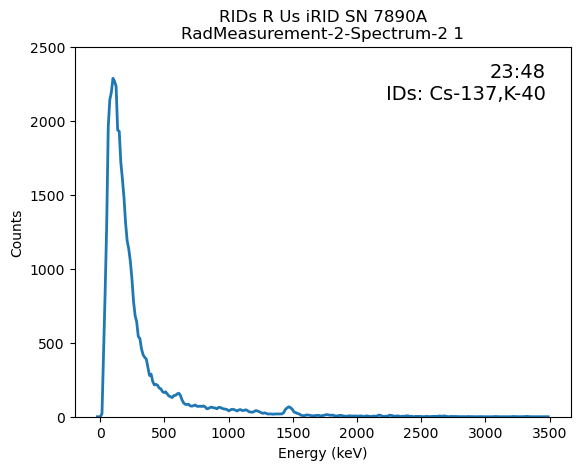

' '

In [7]:
import matplotlib.pyplot as plt
import regex as re

def plot_gamma_spectra(energies, counts,
                       RadInstrumentManufacturerName,
                       RadInstrumentModelName,
                       RadInstrumentIdentifier,
                       StartDateTime,RealTimeDuration,SpectrumID,
                       text='',title_append='',directory='',
                      ylim=None,xlabel="",ylabel=""):
    datetime = '-'.join(re.findall("\d+", str(StartDateTime)))
    fig, ax = plt.subplots()
    ax.plot(energies, counts, linewidth=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # ax = spectra.plot()
    # plt.xscale("log")
    if ylim:
        ax.set_ylim(0,ylim)
    # fig = ax.get_figure()
    if text:
        fig.text(.95,.96, text, ha='right',va='top', size=14, transform=ax.transAxes)
    ax.set_title(RadInstrumentManufacturerName + ' ' + RadInstrumentModelName + ' '
                + str(RadInstrumentIdentifier) + '\n' + str(SpectrumID)
                 + ' ' + title_append)
    if directory != '':
        # display('not show')
        fig.savefig(directory + 'spectrum_' + '_' + str(datetime) + '_' + str(SpectrumID) 
                    + str(RadInstrumentModelName) + '.png', dpi=150)
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

df_fg = df_n42_repl.loc[df_n42_repl['msr_mcc']=='Foreground'].copy()
# df_fg = df_n42_repl.copy()
# display(df_fg['msr_spectrum_channeldata'].iloc[0])
# Energies (x axis), know in this case will be the same for all spectra
channels = np.arange(len(df_fg['msr_spectrum_channeldata'].iloc[0]))
energies = np.polyval([df_fg['calib_coef_2'].iloc[0], df_fg['calib_coef_1'].iloc[0], df_fg['calib_coef_0'].iloc[0]], channels)
# Plot first spectra in notebook as demonstration
df_fg.iloc[[0]].apply(lambda x:
    plot_gamma_spectra(energies, x['msr_spectrum_channeldata'],
                       x['instrument_manuf'],
                       x['instrument_model'],
                       x['instrument_identifier'],
                       x['msr_startdt'],x['msr_realtime'],x['msr_spectrum_id'],
                       text=x['msr_time'] + '\n IDs: ' + ','.join(x['result_nucldies']),
                       title_append=str(x['index']), 
                       ylim=2500,
                      xlabel="Energy (keV)",ylabel="Counts")
,axis='columns')

# Saves plots for all spectra in dataframe
df_fg.apply(lambda x:
    plot_gamma_spectra(energies, x['msr_spectrum_channeldata'],
                       x['instrument_manuf'],
                       x['instrument_model'],
                       x['instrument_identifier'],
                       x['msr_startdt'],x['msr_realtime'],x['msr_spectrum_id'],
                       text=x['msr_time'] + '\n IDs: ' + ','.join(x['result_nucldies']),
                       title_append=str(x['index']), ylim=2500,
                       directory='plots_1/',
                      xlabel="Energy (keV)",ylabel="Counts")
,axis='columns')
display(' ')

## Spectra Plots to GIF
I've found creating GIFs of spectra plots can help to quickly visualize spectra measurement over time. In this case, the effects of the distortion and noise applied to the replicated spectra are seen.

In [8]:
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("N42_replicate_test.gif", format='GIF', append_images=frames[1:],
                   save_all=True, duration=100, loop=0)
print('.')
make_gif('plots_1/')

.


<img src="N42_replicate_test.gif" alt="spectra-gif" style="width:700px;"/>

## Next Time?
- Try other example N42 files in standard, or find other publicly available ones.
- Explore spectra analyses, e.g., FWHM
- Fancier plots
    - Mark where isotope energy lines are expected to be.
    - Red/green text for false/true IDs
- Framework try learning SQL too